## Load Libraries

In [ ]:
from google.colab import files
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import DBSCAN
from sklearn.ensemble import IsolationForest

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

import matplotlib.pyplot as plt
from matplotlib import cm

## Load WBA Data

In [ ]:
# re upload files everytime run

uploaded = files.upload()

Saving X_test.csv to X_test.csv
Saving X_train.csv to X_train.csv
Saving y_test.csv to y_test.csv
Saving y_train.csv to y_train.csv


In [ ]:
X_train = pd.read_csv('X_train.csv')
y_train = pd.read_csv('y_train.csv')
X_test = pd.read_csv('X_test.csv')
y_test = pd.read_csv('y_test.csv')

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

frames_X = [X_train, X_test]
frames_y = [y_train, y_test]

X = pd.concat(frames_X)
y = pd.concat(frames_y)

print(X.shape)
print(y.shape)

(191, 120)
(191, 1)
(48, 120)
(48, 1)
(239, 120)
(239, 1)


In [ ]:
# create datasets

wba = X.copy()
wba_FO = X.iloc[:,13:].copy() # features only

scalerMM = MinMaxScaler()
scalerSS = StandardScaler()
scalerRS = RobustScaler(quantile_range=(10.0,90.0))

wba_MM = scalerMM.fit_transform(X)
wba_MM = pd.DataFrame(wba_MM, columns = X.columns)
wba_MM_FO = wba_MM.iloc[:,13:].copy()

wba_SS = scalerSS.fit_transform(X)
wba_SS = pd.DataFrame(wba_SS, columns = X.columns)
wba_SS_FO = wba_SS.iloc[:,13:].copy()

wba_RS = scalerRS.fit_transform(X)
wba_RS = pd.DataFrame(wba_RS, columns = X.columns)
wba_RS_FO = wba_RS.iloc[:,13:].copy()

In [ ]:
datasets = {0: wba, 1: wba_FO, 2: wba_MM, 3: wba_MM_FO, 4: wba_SS, 5: wba_SS_FO, 6: wba_RS, 7: wba_RS_FO}
#for key in datasets:
#  print(datasets[0].head())
len(datasets)

8

## DBSCAN on WBA Data

In [ ]:
results = pd.DataFrame(columns = ["dataset","eps","min_samples","accuracy","precision","recall","f1_score"]) # store results of hyperparameter testing
counter = 0
eps_values = np.arange(1.2,1.8,0.01) # parameters to try
min_sample_values = np.arange(15,22,1)
#datasets = {0: wba, 1: wba_FO, 2: wba_MM, 3: wba_MM_FO, 4: wba_SS, 5: wba_SS_FO, 6: wba_RS, 7: wba_RS_FO}
datasets = {1: wba_FO}
num_iter = len(eps_values) * len(min_sample_values) * len(datasets)
print("number of iterations: ", num_iter)

for eps_val in eps_values:
  for min_samples in min_sample_values:
    for key in datasets:

      outlier_detection = DBSCAN( # fit model for different parameters
          eps = eps_val,
          metric = "euclidean",
          min_samples = min_samples,
          n_jobs = -1
      )

      clusters = outlier_detection.fit_predict(datasets[key]) # -1 is outlier, num indicates subgroup

      wba_y_pred = clusters.copy()
      for i in range(len(wba_y_pred)): # convert clusters to identify anomalous cases
        if wba_y_pred[i] != -1:
          wba_y_pred[i] = 0
      for i in range(len(wba_y_pred)):
        if wba_y_pred[i] == -1:
          wba_y_pred[i] = 1

      results.loc[len(results.index)] = [key, eps_val, min_samples, accuracy_score(y, wba_y_pred), precision_score(y, wba_y_pred), recall_score(y, wba_y_pred), f1_score(y, wba_y_pred)] # store all results in dataframe
      
      if counter % 100 == 0: # print current value to indicate how long left
        print(counter, " iter completed. Currently - eps: " + str(round(eps_val,2)) + " min samples: " + str(min_samples))
      counter = counter + 1

number of iterations:  427
0  iter completed. Currently - eps: 1.2 min samples: 15
100  iter completed. Currently - eps: 1.34 min samples: 17
200  iter completed. Currently - eps: 1.48 min samples: 19
300  iter completed. Currently - eps: 1.62 min samples: 21
400  iter completed. Currently - eps: 1.77 min samples: 16


In [ ]:
print(results["accuracy"].max(), results["accuracy"].idxmax())
print(results["f1_score"].max(), results["f1_score"].idxmax())
print(results["recall"].max(), results["recall"].idxmax())
print(results["precision"].max(), results["precision"].idxmax())
print(results.iloc[152,])
#results.to_csv("mm_161022.csv")

0.8870292887029289 152
0.5573770491803278 152
0.6578947368421053 4
0.875 238
dataset         1.000000
eps             1.410000
min_samples    20.000000
accuracy        0.887029
precision       0.739130
recall          0.447368
f1_score        0.557377
Name: 152, dtype: float64


In [ ]:
outlier_detection = DBSCAN( # fit model for different parameters
          eps = 1.41,
          metric = "euclidean",
          min_samples = 20,
          n_jobs = -1
      )

clusters = outlier_detection.fit_predict(datasets[1]) # -1 is outlier, num indicates subgroup

wba_y_pred = clusters.copy()
for i in range(len(wba_y_pred)): # convert clusters to identify anomalous cases
  if wba_y_pred[i] != -1:
    wba_y_pred[i] = 0
for i in range(len(wba_y_pred)):
  if wba_y_pred[i] == -1:
    wba_y_pred[i] = 1

print(accuracy_score(y, wba_y_pred))
print(confusion_matrix(y, wba_y_pred))
print(classification_report(y, wba_y_pred))

0.8870292887029289
[[195   6]
 [ 21  17]]
              precision    recall  f1-score   support

           0       0.90      0.97      0.94       201
           1       0.74      0.45      0.56        38

    accuracy                           0.89       239
   macro avg       0.82      0.71      0.75       239
weighted avg       0.88      0.89      0.88       239



In [ ]:
len(np.unique(clusters))

2

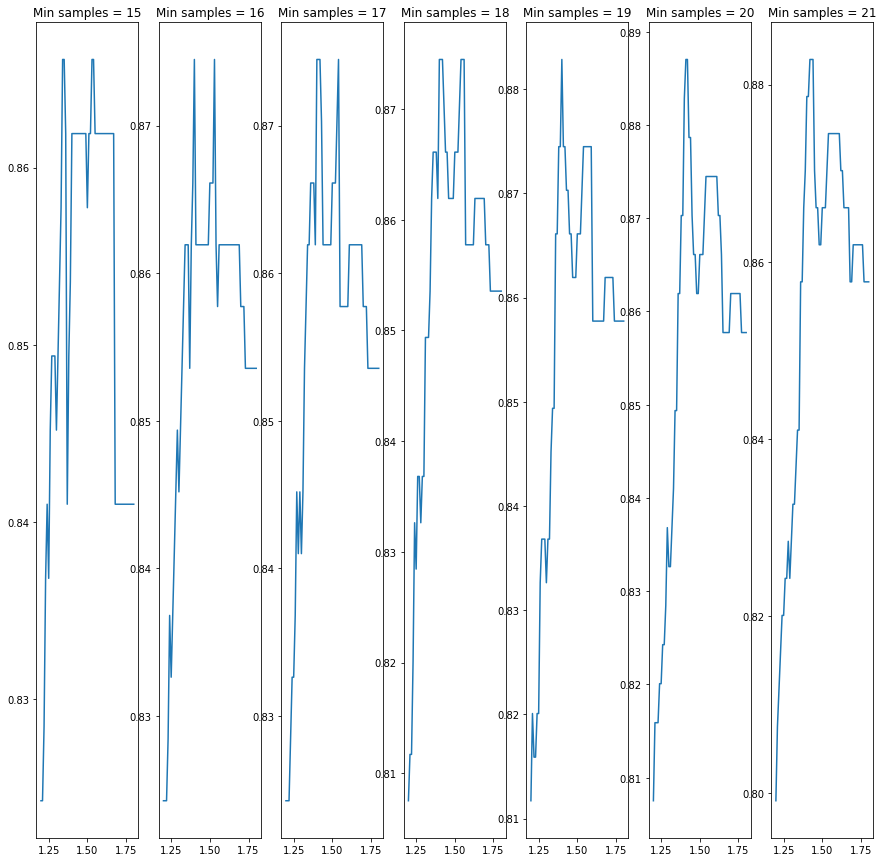

In [ ]:
fig, ax = plt.subplots(nrows=len(datasets), ncols=len(min_sample_values), figsize=(15, 15))

for row in datasets:
  col = 0
  for j in min_sample_values:
    ax[col].plot(results.loc[(results["min_samples"] == j) & (results["dataset"] == row),"eps"],results.loc[(results["min_samples"] == j) & (results["dataset"] == row),"accuracy"])
    ax[col].title.set_text("Min samples = " + str(j) )
    col = col + 1

## Other Tests

In [ ]:
(dbscan1['DBSCAN'] == -1) & (dbscan1['OverallPoF'] == 0)

0     False
1     False
2     False
3     False
4     False
      ...  
43    False
44    False
45    False
46    False
47    False
Length: 239, dtype: bool

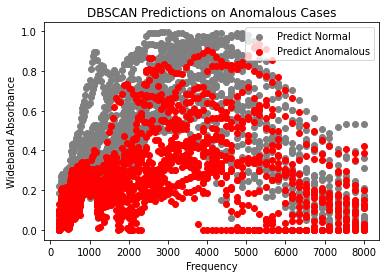

In [ ]:
dbscan1 = X.copy()
dbscan1['Id'] = np.arange(len(dbscan1))
dbscan1['DBSCAN'] = clusters
dbscan1['OverallPoF'] = y['OverallPoF']

dbscan1 = pd.melt(dbscan1.loc[(dbscan1['OverallPoF'] == 1),], id_vars=['Id','DBSCAN'], value_vars=['f(226.0000)','f(257.3256)','f(280.6155)','f(297.3018)','f(324.2099)','f(343.4884)','f(363.9133)','f(385.5527)','f(408.4789)','f(432.7683)','f(458.5020)','f(471.9372)','f(500.0000)','f(514.6511)','f(545.2539)','f(561.2310)','f(577.6763)','f(594.6036)','f(629.9605)','f(648.4198)','f(667.4199)','f(686.9768)','f(707.1068)','f(727.8266)','f(749.1535)','f(771.1054)','f(793.7005)','f(816.9577)','f(840.8964)','f(865.5366)','f(890.8987)','f(917.0040)','f(943.8743)','f(971.5319)','f(1000.0000)','f(1029.3022)','f(1059.4631)','f(1090.5077)','f(1122.4620)','f(1155.3527)','f(1189.2071)','f(1224.0535)','f(1259.9210)','f(1296.8396)','f(1334.8399)','f(1373.9536)','f(1414.2136)','f(1455.6532)','f(1498.3071)','f(1542.2108)','f(1587.4011)','f(1633.9155)','f(1681.7928)','f(1731.0731)','f(1781.7974)','f(1834.0081)','f(1887.7486)','f(1943.0639)','f(2000.0000)','f(2058.6045)','f(2118.9262)','f(2181.0155)','f(2244.9241)','f(2310.7054)','f(2378.4142)','f(2448.1071)','f(2519.8421)','f(2593.6791)','f(2669.6797)','f(2747.9073)','f(2828.4271)','f(2911.3064)','f(2996.6142)','f(3084.4217)','f(3174.8021)','f(3267.8309)','f(3363.5857)','f(3462.1462)','f(3563.5949)','f(3668.0162)','f(3775.4973)','f(3886.1278)','f(4000.0000)','f(4117.2089)','f(4237.8524)','f(4362.0309)','f(4489.8482)','f(4621.4108)','f(4756.8285)','f(4896.2142)','f(5039.6842)','f(5187.3582)','f(5339.3594)','f(5495.8146)','f(5656.8542)','f(5822.6127)','f(5993.2283)','f(6168.8433)','f(6349.6042)','f(6535.6618)','f(6727.1713)','f(6924.2925)','f(7127.1897)','f(7336.0323)','f(7550.9945)','f(7772.2555)','f(8000.0000)'], var_name='Frequency', value_name='WBA')
dbscan1['Frequency'] = dbscan1['Frequency'].str[2:-1].astype(float)

pred_normal = dbscan1.loc[dbscan1['DBSCAN']==0,:]
pred_anomalous = dbscan1.loc[dbscan1['DBSCAN']==-1,:]

cmap = cm.get_cmap('Set1')
plt.scatter(pred_normal["Frequency"], pred_normal["WBA"], c="grey", label="Predict Normal")
plt.scatter(pred_anomalous["Frequency"], pred_anomalous["WBA"], c="red", label="Predict Anomalous")
plt.xlabel("Frequency")
plt.ylabel("Wideband Absorbance")
plt.title("DBSCAN Predictions on Anomalous Cases")
plt.legend(loc="upper right")
plt.show()

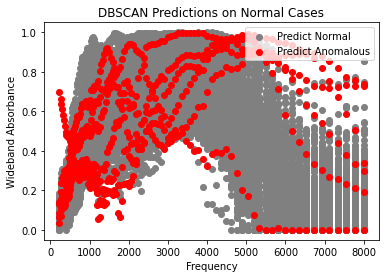

In [ ]:
dbscan1 = X.copy()
dbscan1['Id'] = np.arange(len(dbscan1))
dbscan1['DBSCAN'] = clusters
dbscan1['OverallPoF'] = y['OverallPoF']

dbscan1 = pd.melt(dbscan1.loc[(dbscan1['OverallPoF'] == 0),], id_vars=['Id','DBSCAN'], value_vars=['f(226.0000)','f(257.3256)','f(280.6155)','f(297.3018)','f(324.2099)','f(343.4884)','f(363.9133)','f(385.5527)','f(408.4789)','f(432.7683)','f(458.5020)','f(471.9372)','f(500.0000)','f(514.6511)','f(545.2539)','f(561.2310)','f(577.6763)','f(594.6036)','f(629.9605)','f(648.4198)','f(667.4199)','f(686.9768)','f(707.1068)','f(727.8266)','f(749.1535)','f(771.1054)','f(793.7005)','f(816.9577)','f(840.8964)','f(865.5366)','f(890.8987)','f(917.0040)','f(943.8743)','f(971.5319)','f(1000.0000)','f(1029.3022)','f(1059.4631)','f(1090.5077)','f(1122.4620)','f(1155.3527)','f(1189.2071)','f(1224.0535)','f(1259.9210)','f(1296.8396)','f(1334.8399)','f(1373.9536)','f(1414.2136)','f(1455.6532)','f(1498.3071)','f(1542.2108)','f(1587.4011)','f(1633.9155)','f(1681.7928)','f(1731.0731)','f(1781.7974)','f(1834.0081)','f(1887.7486)','f(1943.0639)','f(2000.0000)','f(2058.6045)','f(2118.9262)','f(2181.0155)','f(2244.9241)','f(2310.7054)','f(2378.4142)','f(2448.1071)','f(2519.8421)','f(2593.6791)','f(2669.6797)','f(2747.9073)','f(2828.4271)','f(2911.3064)','f(2996.6142)','f(3084.4217)','f(3174.8021)','f(3267.8309)','f(3363.5857)','f(3462.1462)','f(3563.5949)','f(3668.0162)','f(3775.4973)','f(3886.1278)','f(4000.0000)','f(4117.2089)','f(4237.8524)','f(4362.0309)','f(4489.8482)','f(4621.4108)','f(4756.8285)','f(4896.2142)','f(5039.6842)','f(5187.3582)','f(5339.3594)','f(5495.8146)','f(5656.8542)','f(5822.6127)','f(5993.2283)','f(6168.8433)','f(6349.6042)','f(6535.6618)','f(6727.1713)','f(6924.2925)','f(7127.1897)','f(7336.0323)','f(7550.9945)','f(7772.2555)','f(8000.0000)'], var_name='Frequency', value_name='WBA')
dbscan1['Frequency'] = dbscan1['Frequency'].str[2:-1].astype(float)

pred_normal = dbscan1.loc[dbscan1['DBSCAN']==0,:]
pred_anomalous = dbscan1.loc[dbscan1['DBSCAN']==-1,:]

cmap = cm.get_cmap('Set1')
plt.scatter(pred_normal["Frequency"], pred_normal["WBA"], c="grey", label="Predict Normal")
plt.scatter(pred_anomalous["Frequency"], pred_anomalous["WBA"], c="red", label="Predict Anomalous")
plt.xlabel("Frequency")
plt.ylabel("Wideband Absorbance")
plt.title("DBSCAN Predictions on Normal Cases")
plt.legend(loc="upper right")
plt.show()